<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#305496; font-size:40px'>Aprendizagem de máquina para corrigir os dados do sensor do peso sobre a broca</h1>
</div>

Na perfuração de poços de petróleo são utilizados equipamentos compostos por uma sequência de tubos e em sua extremidade uma broca que fragmenta a rocha no fundo do poço a partir de uma rotação e um peso aplicado sobre toda a estrutura, chamado de coluna de perfuração. 

Sensores estão acoplados aos diversos equipamentos de perfuração para o monitoramente, porém, esses dispostitivos estão sucetíveis a falhas acarretando na falta dos dados.

Nesse trabalho será aplicado um modelo de aprendizagem de máquina para corrigir os dados faltantes do peso sobre a broca, também conhecido como Weight on BIt (WOB).

O algoritmo verifica para cada registro de dados se é referente a perfuração em andamento, WOB é nulo e as demais variáveis não são nulas, como condição para o modelo estimar o WOB, e na sequência expor em gráficos a correção do peso sobre a broca.


<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#305496; font-size:40px'>Machine learning to correct weight on bit in drilling data</h1>
</div>

In the drilling of oil wells, equipment is used composed of a sequence of pipes and at its end, a drill that fragments the rock at the bottom of the well from a rotation and a weight applied over the entire structure called a drill string.

Sensors are coupled to the various drilling equipment for monitoring, however, these devices are susceptible to failures resulting in the missing data.

In this work, a machine learning model will be applied to correct the missing data about weight on the drill bit, also known as WOB.

The algorithm checks for each data record if it refers to drilling in progress, WOB is null and the other variables are not null, as a condition for the model to estimate the WOB, and then display in graphics the correction to the weight on bit variable.

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Upload the packages</h2>
</div>

In [13]:
%matplotlib inline

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

print(f'XGBoost version: {xgb.__version__}')

XGBoost version: 1.6.1


<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Upload the model</h2>
</div>

The model was made up of the linear regression by XGBoost algorithm.

In [14]:
# Upload the model specialized in replace WOB missing data.

model_name = 'model.json'
model = xgb.XGBRegressor(tree_method='gpu_hist')
model.load_model(model_name)


<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Define the constants</h2>
</div>


In [15]:
# Define the file name tha has drilling data.

file = 'drilling_data.csv'

In [16]:
features = [
    'DRG', 'RPM', 'TOB', 'GPM', 'WOH', 'ECD',
    'HHT', 'SPP', 'STS', 'ROP'
]


# File segments with significant missing data.
segments = [(1510099230, 1510110900), (1510072800, 1510099191)]

# File indexes with significant missing data.
indexes = [[i for i in range(50560, 50610)], [i for i in range(49740, 49900)]]

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Define the support functions</h2>
</div>

In [17]:
def is_suitable(row):
    '''
        The row is suitable if there isn't any missing data.
       
        The goal is to avoid inserting in the model missing data.
    '''
    suitable = True
    for feature in features:
        if np.isnan(row[feature]):
            suitable = False
            break
    return suitable

def print_estimtion(df, segment):
    '''
        The goal is to check out the data.
    '''
    df_1 = df.loc[indexes[segment]][['time', 'WOB', 'wob_pred']]
    print(df_1)
    return

def plot_predictions(df, segment):
    # Select file segment.
    (initial, final) = segments[segment]
    df_1 = df.loc[(df['time'] >= initial) & (df['time'] <=  final)]

    # Prepare plot area.
    fig, axs = plt.subplots(2, 1, constrained_layout=True)
    fig.suptitle('Extração do segmento '+str(segment))

    # Plot WOB with missing data.
    df_1['WOB'].plot(ax=axs[0])
    axs[0].set_title('Dados perdidos')
    axs[0].legend(loc='best')

    # Plot WOB with replaced estimating data.
    df_1['wob_pred'].plot(ax=axs[1])
    axs[1].set_title('Dados substituídos')
    axs[1].legend(loc='best')

    # Show plot.
    plt.show()
    plt.close()
    return


<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Algorithm to estimate the WOB to replace the missing data</h2>
</div>

In [18]:
# Open file to get drilling data.
df = pd.read_csv(file, sep=';', header=0, low_memory=False, memory_map=True)

# Show the data structure.
print(df.info())

# Estmate the WOB for each missing value.
last_wob = 0
wob_preds = []
for i in range(len(df)):
    # Get record.
    row = df.iloc[i].to_dict()
    row['bit_to_depth'] = row['DEPTH'] - row['BIT_DEPTH']
    if row['bit_to_depth'] < 1: # If teh record is about drilling.
        if np.isnan(row['WOB']): # If there isn't WOB value.
            if is_suitable(row): # If other features are suitable.
                # Estimate the WOB.
                df_1 = df.iloc[[i]][features]
                df_1['bit_to_depth'] = row['bit_to_depth']
                X = df_1.round(decimals=1)
                wob_pred = model.predict(X)[0]
                if wob_pred < 0: wob_pred = last_wob
                wob_preds.append(wob_pred)
            else:
                # There are some missing data.
                wob_preds.append(last_wob)
        else:
            # The WOB value is not missing.
            last_wob = row['WOB']
            wob_preds.append(last_wob)
    else:
        # The row is about another operation.
        if np.isnan(row['WOB']):
            wob_preds.append(last_wob)
        else:
            last_wob = row['WOB']
            wob_preds.append(last_wob)

# Save estimated WOB merged with original WOB.
df['wob_pred'] = wob_preds
file = 'drilling_data_pwob.csv'
df.to_csv(file, sep=';', decimal=',', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63037 entries, 0 to 63036
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       63037 non-null  int64  
 1   WOB        58613 non-null  float64
 2   DRG        62968 non-null  float64
 3   RPM        63030 non-null  float64
 4   BRS        55698 non-null  float64
 5   DSSA       62971 non-null  float64
 6   TOB        63030 non-null  float64
 7   GPM        63030 non-null  float64
 8   WOH        63030 non-null  float64
 9   HHT        63030 non-null  float64
 10  BIT_DEPTH  63030 non-null  float64
 11  DEPTH      63030 non-null  float64
 12  SLP        52565 non-null  float64
 13  ECD        46837 non-null  float64
 14  SPP        63030 non-null  float64
 15  STS        49248 non-null  float64
 16  ROP        63032 non-null  float64
 17  AZT        20712 non-null  float64
 18  DSSB       62347 non-null  float64
 19  APR        53061 non-null  float64
 20  PDF   

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Display in graphics the corrections of WOB</h2>
</div>

Two cases

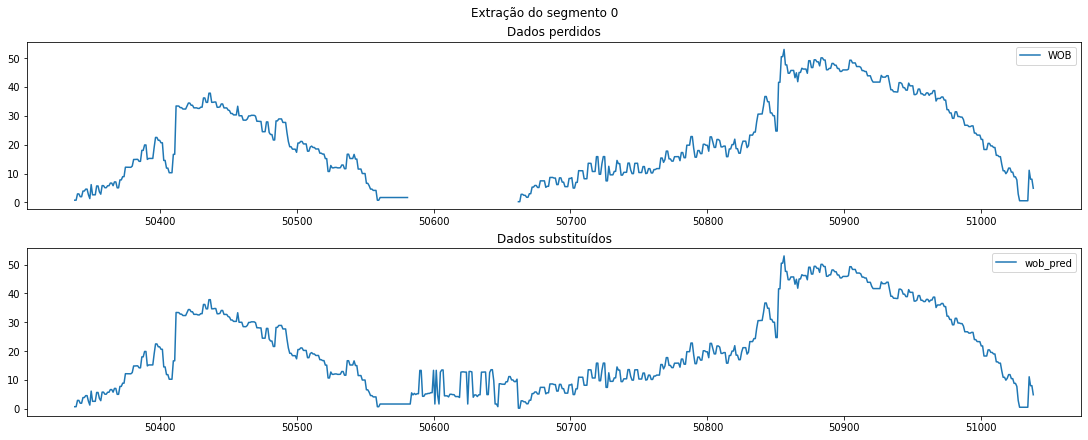

In [19]:
# Plot and print missing data and the values have been replaced to be compared.
plot_predictions(df, segment=0)
#print_estimtion(df, segment=0)

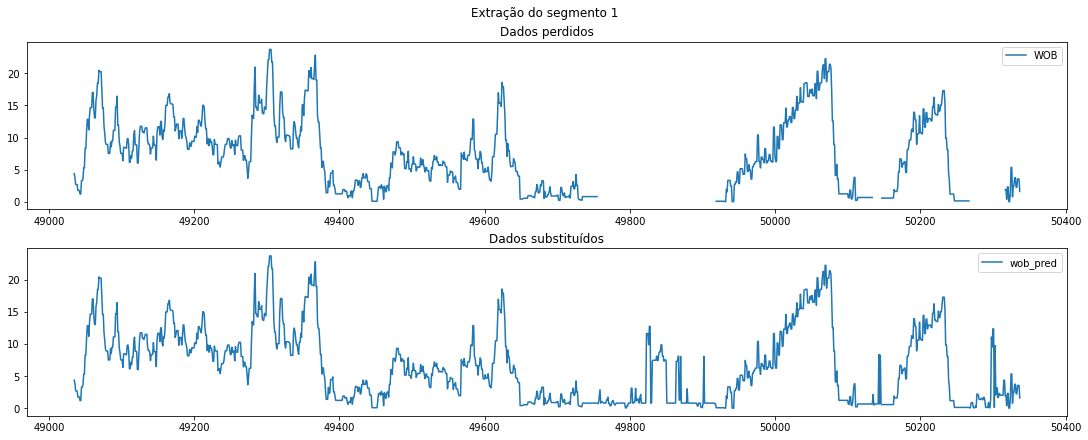

In [20]:
plot_predictions(df, segment=1)
#print_estimtion(df, segment=1)